# <span style="color:green">Project: Credit Card Transaction Anomaly Detection
## <span style="color:green">Author: Naveed Khan (naveedk786@yahoo.com)
***

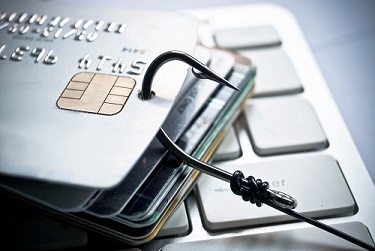

<a id="project-overview"></a>
# <span style="color:blue">Project Overview
 

<div class="alert alert-block alert-info"> 

### 1.  Build an Anomaly detection model to reduce Bank’s monetary losses due to fraudulent credit card transactions.
### 2.  Develop tools to detect customers spending exceeding their credit limit.


<a id="I"></a>

# <span style="color:blue"> Part 1.  Reading Data & Exploratory Data Analysis 

### 1. Importing necessary Libraries 


In [2]:
# Importing the libraries
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()  #  Will import Seaborn functionalities

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report,accuracy_score
from sklearn.svm import OneClassSVM
from pylab import rcParams

# we don't like warnings
# you can comment the following 2 lines if you'd like to
import warnings
warnings.filterwarnings('ignore')

### 2. Read csv files 


#### Read both the files first ('tx_data.csv' and 'cc_info.csv')

In [2]:
anomaly_detection_1 = pd.read_csv('tx_data.csv', index_col=False) 
anomaly_detection_2 = pd.read_csv('cc_info.csv', index_col=False) 

In [ ]:
#anomaly_detection_combined = pd.read_csv('anomaly_detection_combined_File1.csv', index_col=False) 

#### Merge the two .csv files 

In [3]:
anomaly_detection_combined = pd.merge(anomaly_detection_2, anomaly_detection_1, 
                                      left_on='cc_number', right_on = 'cc_number', how = 'left' )

### 3.  Lets get the overall sense of the Dataframe

Lets look at a few functions which will be critical to understand the data. 

- `shape` - determine number of rows and columns
- `info` - General information and identify null rows
- `len` - length of rows
- `describe` - 5 numbers summary


In [4]:
anomaly_detection_combined.shape

(233043, 9)

In [5]:
anomaly_detection_combined.head(5)

,user_id,zipcode,state,cc_number,cc_limit,date,transaction,long,lat
0,29421272,3280,NH,4983684529421272,10000,2016-08-11 19:14:06,44.65,-72.174098,43.156873
1,29421272,3280,NH,4983684529421272,10000,2016-06-10 22:09:53,5.68,-72.131747,43.213248
2,29421272,3280,NH,4983684529421272,10000,2016-07-27 04:18:40,63.19,-72.022366,43.161782
3,29421272,3280,NH,4983684529421272,10000,2016-05-27 00:39:42,122.04,-72.159013,43.235530
4,29421272,3280,NH,4983684529421272,10000,2016-08-15 22:14:28,53.66,-72.169355,43.170859


Let’s have a look at data dimensionality, features names, and feature types.

In [32]:
anomaly_detection_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233043 entries, 0 to 233042
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   user_id      233043 non-null  int64         
 1   zipcode      233043 non-null  int64         
 2   cc_limit     233043 non-null  int64         
 3   date         233043 non-null  datetime64[ns]
 4   transaction  233043 non-null  float64       
 5   long         233043 non-null  float64       
 6   lat          233043 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3)
memory usage: 24.2 MB



`int64`, `float64` and `object` are the data types of our features. 

- 1 feature "date" is Categorical `object`
- 1 feature "state" is Categorical(Nominal) `object`
- 7 features are numeric of types: `int64` and `float64`. 

- There is no missing value(non-null) as every feature has 233043 counts


Run some basic statistical charactersistic of the numerical features: 
mean, standard deviation, range, 0.25, median, and 0.75 quartiles.

In [33]:
anomaly_detection_combined.describe() 

,user_id,zipcode,cc_limit,transaction,long,lat
count,2.330430e+05,233043.000000,233043.000000,233043.000000,233043.000000,233043.000000
mean,5.065137e+07,18411.574851,12801.478697,77.515636,-76.486116,40.914953
std,2.930390e+07,24531.477690,5015.120164,122.244587,20.361250,5.396546
min,1.541420e+05,690.000000,2000.000000,0.010000,-179.392887,-66.735588
25%,2.426510e+07,3280.000000,9000.000000,27.160000,-80.220837,40.421894
50%,5.150837e+07,5343.000000,12000.000000,52.240000,-72.807566,42.490085
75%,7.581502e+07,18612.000000,18000.000000,88.020000,-72.091062,43.180160
max,9.974543e+07,98401.000000,20000.000000,999.970000,179.917513,78.914330


In [9]:
# group by the 'label' and show descriptive stats
# anomaly_detection_combined.groupby('transaction').agg(['count', 'mean','std','min','max','median']).T.head()

transaction          0.01          0.02          0.03          0.04    \
user_id count  3.400000e+01  1.600000e+01  3.400000e+01  2.000000e+01   
        mean   4.644571e+07  5.791271e+07  4.488543e+07  5.443936e+07   
        std    2.705875e+07  2.722072e+07  3.118336e+07  3.276250e+07   
        min    1.541420e+05  1.029565e+06  5.601122e+06  4.454820e+06   
        max    9.639887e+07  9.885468e+07  9.609398e+07  9.750599e+07   

transaction          0.05          0.06          0.07          0.08    \
user_id count  1.400000e+01  1.700000e+01  2.000000e+01  1.500000e+01   
        mean   4.996538e+07  5.045508e+07  5.979318e+07  5.480203e+07   
        std    2.848911e+07  2.147060e+07  2.882618e+07  3.156551e+07   
        min    4.454820e+06  1.029565e+06  4.454820e+06  1.154858e+07   
        max    9.469961e+07  8.335638e+07  9.643080e+07  9.459515e+07   

transaction          0.09          0.10    ...      999.54      999.56  \
user_id count  1.200000e+01  3.400000e+01  ...         1.0         1.0   
        mean   5.526854e+07  4.682912e+07  ...  17439717.0  86283357.0   
        std    2.843556e+07  3.140000e+07  ...         NaN         NaN   
        min    6.444100e+06  1.406445e+06  ...  17439717.0  86283357.0   
        max    9.664875e+07  9.842699e+07  ...  17439717.0  86283357.0   

transaction        999.68      999.69      999.70      999.82      999.90  \
user_id count         1.0         1.0         1.0         1.0         1.0   
        mean   65505239.0  17667855.0  67750871.0  11058115.0  35025321.0   
        std           NaN         NaN         NaN         NaN         NaN   
        min    65505239.0  17667855.0  67750871.0  11058115.0  35025321.0   
        max    65505239.0  17667855.0  67750871.0  11058115.0  35025321.0   

transaction        999.95      999.96      999.97  
user_id count         1.0         1.0         1.0  
        mean   10321688.0  41098058.0  75815022.0  
        std           NaN         NaN         NaN  
        min    10321688.0  41098058.0  75815022.0  
        max    10321688.0  41098058.0  75815022.0  

[5 rows x 25205 columns]

### In order to see statistics on non-numerical features, one has to explicitly indicate data types of interest in 

### the `include` parameter.

In [ ]:
# anomaly_detection_combined.describe(include=['object', 'bool', 'category'])

For categorical (type `object`) features, we can use the `value_counts` method. Let’s have a look at the distribution of  `state`:

In [11]:
anomaly_detection_combined['state'].value_counts()

NH    97819
PA    36193
NY    20359
IL    12779
MA    10650
WV     6206
NJ     4784
VT     4289
CA     3786
ME     3513
TX     3179
GA     2627
OK     2216
PR     2107
IN     2058
NM     2055
IA     1933
OH     1879
WA     1612
MO     1552
AL     1389
CT     1082
FL     1017
VA      896
ID      858
HI      839
LA      833
MI      812
MD      796
RI      689
AZ      619
UT      548
CO      532
NC      484
KS       53
Name: state, dtype: int64

#### Lets look at the fractions or % distribution of the states using `normalize=True` to the `value_counts` function.

In [12]:
(anomaly_detection_combined['state'].value_counts(normalize=True))*100

NH    41.974657
PA    15.530610
NY     8.736156
IL     5.483537
MA     4.569972
WV     2.663028
NJ     2.052840
VT     1.840433
CA     1.624593
ME     1.507447
TX     1.364126
GA     1.127260
OK     0.950897
PR     0.904125
IN     0.883099
NM     0.881812
IA     0.829461
OH     0.806289
WA     0.691718
MO     0.665972
AL     0.596027
CT     0.464292
FL     0.436400
VA     0.384478
ID     0.368172
HI     0.360019
LA     0.357445
MI     0.348434
MD     0.341568
RI     0.295654
AZ     0.265616
UT     0.235150
CO     0.228284
NC     0.207687
KS     0.022743
Name: state, dtype: float64

#### "NH" has the most transactions followed by "PA", "NY" and "IL"

<a id="II"></a>

# <span style="color:blue"> Part 2.  Visual Data Analysis 


Below, we will consider different statistical types of features and the corresponding tools for their individual visual analysis.

1.1 Quantitative features
Quantitative features take on ordered numerical values. Those values can be discrete, like integers, or continuous, like real numbers, and usually express a count or a measurement.

1.1.1 Histograms and density plots
The easiest way to take a look at the distribution of a numerical variable is to plot its histogram using the DataFrame's method hist().

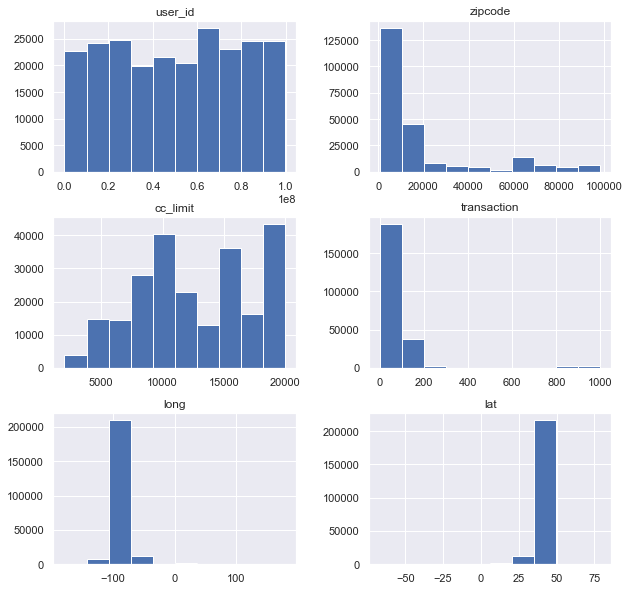

In [14]:
features = ['user_id', 'zipcode', 'cc_limit', 'date', 'transaction', 'long', 'lat']

anomaly_detection_combined[features].hist(figsize=(10, 10));

There is also another, often clearer, way to grasp the distribution: *density plots* or, more formally, *Kernel Density Plots*. They can be considered a [smoothed](https://en.wikipedia.org/wiki/Kernel_smoother) version of the histogram. Their main advantage over the latter is that they do not depend on the size of the bins. Let's create density plots for the same two variables:

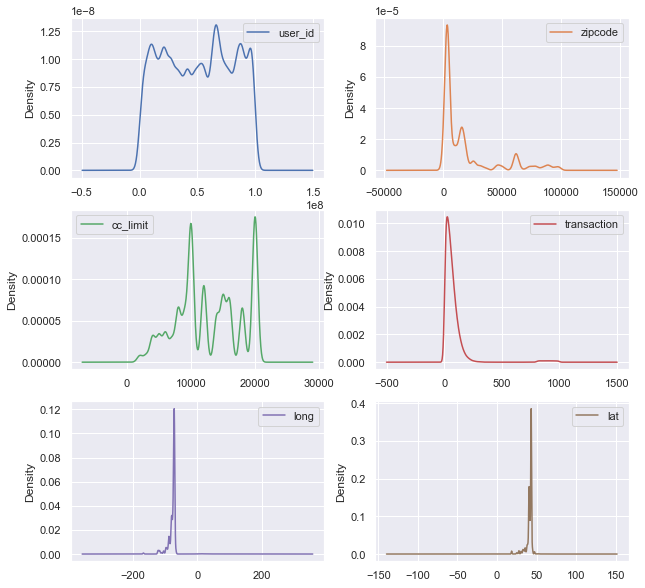

In [17]:
anomaly_detection_combined[features].plot(kind='density', subplots=True, layout=(3, 2), 
                  sharex=False, figsize=(10, 10));

<AxesSubplot:>

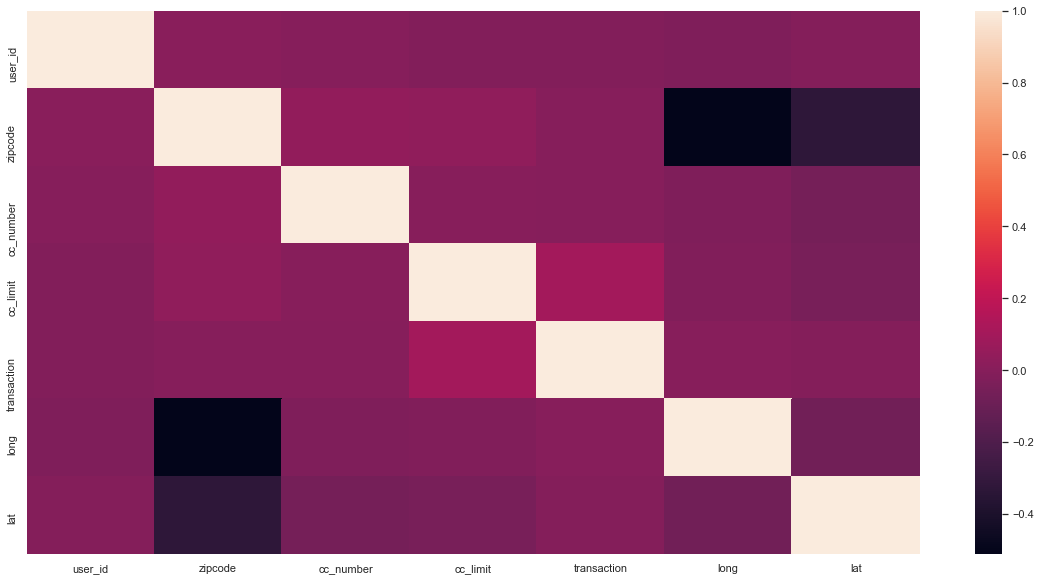

In [19]:
#### 4.2 Correlation heatmap of the numberic variables
plt.rcParams['figure.figsize'] = 20,10  # control plot sizeimport seaborn as sns
sns.heatmap(anomaly_detection_combined.corr())

* Above Heatmap indicates lack of correlation among the numerical features.

<a id="III"></a>

# <span style="color:blue"> Part 3. Data Pre-processing &  Preparation

## <span style="color:blue">Feature Selection</span>


### Remove 'state' and 'cc_number' columns being redundant and not improtant

In [21]:
feat_sel = ['user_id', 'zipcode', 'cc_limit', 'date', 'transaction', 'long', 'lat']

anomaly_detection_combined = anomaly_detection_combined[feat_sel]

In [22]:
anomaly_detection_combined.head()

,user_id,zipcode,cc_limit,date,transaction,long,lat
0,29421272,3280,10000,2016-08-11 19:14:06,44.65,-72.174098,43.156873
1,29421272,3280,10000,2016-06-10 22:09:53,5.68,-72.131747,43.213248
2,29421272,3280,10000,2016-07-27 04:18:40,63.19,-72.022366,43.161782
3,29421272,3280,10000,2016-05-27 00:39:42,122.04,-72.159013,43.235530
4,29421272,3280,10000,2016-08-15 22:14:28,53.66,-72.169355,43.170859


### Converting 'date' into datetime

In [23]:
#Below is the first part of the code
from datetime import datetime

# Converting 'date' from object to datetime type

anomaly_detection_combined['date']= pd.to_datetime(anomaly_detection_combined['date'], format= '%Y/%m/%d %H:%M:%S')

In [24]:
anomaly_detection_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233043 entries, 0 to 233042
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   user_id      233043 non-null  int64         
 1   zipcode      233043 non-null  int64         
 2   cc_limit     233043 non-null  int64         
 3   date         233043 non-null  datetime64[ns]
 4   transaction  233043 non-null  float64       
 5   long         233043 non-null  float64       
 6   lat          233043 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3)
memory usage: 24.2 MB


#### The `date` has been converted from "object" type to "datetime64" type

<a id="IV"></a>
##  <span style="color:blue"> Part 4. Calculate Geodistance between Transaction location and Card Holder Home location</span>

### Step 1:  Install packages and import libraries
### Step 2:  Initiate connection with 'geocoder' using API key
### Step 3:  Initiate 'SearchEngine' to locate 'zipcode'
### Step 4:  Convert Card Holder Home Zipcode to Longitude and Latitude
### Step 5:  Finding the distance between Long & Lat from Step 4 and Transaction Long & Lat.



Geocoding and Reverse Geocoding using Python
* #url: https://towardsdatascience.com/geocoding-and-reverse-geocoding-using-python-36a6ad275535



In [34]:
#!pip install opencage

In [ ]:
# !pip install folium

#### Step 1: Install packages and import libraries

In [25]:
import pandas as pd
from opencage.geocoder import OpenCageGeocode
import folium
from folium.plugins import FastMarkerCluster

#### Step 2: Initiate connection with 'geocoder' using API key

In [27]:
# Establishing the API with 'geocoder' using the key

key = "428ff664b5ce416d839e130fb51c49d8"
geocoder = OpenCageGeocode(key)
address='1108 ROSS CLARK CIRCLE,DOTHAN,HOUSTON,AL'     # Verifying the API is working
result = geocoder.geocode(address, no_annotations="1") # Verifying the API is working 
result[0]['geometry']                                  # Verifying the API is working 

{'lat': 31.216402, 'lng': -85.3656406}

#### Step 3: Initiate 'SearchEngine' to locate 'zipcode'

In [30]:
import mpu
from uszipcode import SearchEngine

#for extensive list of zipcodes, set simple_zipcode =False
search = SearchEngine(simple_zipcode=True)


10.202388661400336

#### Verifying mpu.haversine_distance function by passing two sets of Long & Lat

In [35]:
zip1  = search.by_zipcode('3280') # Example: Passing a US Zipcode SearchEngine. This will be search the Zipcode
                                  # Verifying the API is working and returning the lat and long from Zipcode
#print(zip1)

lat1  = zip1.lat
long1 = zip1.lng

lat2  = 31.216402                 # This will be the Transaction Lat
long2 =-85.3656406                 # This will be the Transaction Long

mpu.haversine_distance((lat1,long1),(lat2,long2))  # This line will calculate distance between two sets of
                                                   # long & lat 

1771.7347947890914

#### Visually display Zipcodes and Transaction's Longitude and Latitude <span style="color:red">(Run time > 7 min and may consume lot of memory)

In [ ]:
# folium_map= folium.Map(
#     location=[33.798259,-84.327062],
#     zoom_start=4.4,
#     tiles='CartoDB dark_matter')
# FastMarkerCluster(anomaly_detection_combined[['lat', 'long']].values.tolist()).add_to(folium_map)
# folium.LayerControl().add_to(folium_map)

# for row in anomaly_detection_combined.iterrows():
#     row=row[1]
#     folium.CircleMarker(location=(row["lat"],
#                                    row["long"]),
#                         radius= 1,
#                         color="#007849",
#                         popup=row['zipcode'],
#                         fill=False).add_to(folium_map)
    
# folium_map

#### Step 4: Convert Card Holder Home Zipcode to Longitude and Latitude

In [36]:
# Creating lists to store Home Zipcodes, translated longitude and latitude from Home Zipcodes
zipHome =[]
lat_trans =[]
long_trans=[]

# Search Home Zipcodes, translated longitude and latitude from Home Zipcodes and store them by appending the lists
for i in range(len(anomaly_detection_combined)):
    zipHome = search.by_zipcode(anomaly_detection_combined.zipcode[i])
    lat1 = zipHome.lat
    long1 = zipHome.lng
    #print('Home lat: ',lat1, '  Home long: ', long1)
    #print()
    lat_trans.append(lat1)
    long_trans.append(long1)

In [ ]:
type(lat_trans)

#### Step 5: Finding the Long & Lat of the Home zipcode <span style="color:red">(Run time ~= 5 min, be patient).
    
##### Create a function to calculate distance between two sets of long & lat using 'mpu.haversine' function    

In [37]:
# Defining a function 'trans_dist_cal' to calculate distance between two sets of Longitude & Latitude 
# using function 'mpu.haversine_distance'

def trans_dis_cal(lat_orig,long_orig,lat_tx,long_tx):
    trans_dist2 = 0
    if lat_orig and long_orig is not None:
        trans_dist2 = mpu.haversine_distance((lat_tx,long_tx),(lat_orig,long_orig))
        return trans_dist2
    else:
        return trans_dist2 ==0
        

##### Creating a list of Translated Distance "trans-dist" to store all the distances from the dataframe using the above function

In [38]:
trans_dist =[]

for i in range(len(anomaly_detection_combined)):
    dist = trans_dis_cal(lat_trans[i],long_trans[i],anomaly_detection_combined.lat[i],anomaly_detection_combined.long[i])
    trans_dist.append(dist)
    

#####  Adding two new columns 'Home_long' and 'Home_lat' to the dataframe. 
#####  These are the Long & Lat values for the Home Zipcodes as calculated above

In [39]:
anomaly_detection_combined['home_long'] = long_trans
anomaly_detection_combined['home_lat']  = lat_trans

##### Creating a new column of the calculated Translated Distance 'tx_distance' to the dataframe & converting into 'int'

In [42]:
ints = [int(item) for item in trans_dist]

anomaly_detection_combined['tx_distance']=ints

In [43]:
anomaly_detection_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233043 entries, 0 to 233042
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   user_id      233043 non-null  int64         
 1   zipcode      233043 non-null  int64         
 2   cc_limit     233043 non-null  int64         
 3   date         233043 non-null  datetime64[ns]
 4   transaction  233043 non-null  float64       
 5   long         233043 non-null  float64       
 6   lat          233043 non-null  float64       
 7   home_long    210412 non-null  float64       
 8   home_lat     210412 non-null  float64       
 9   tx_distance  233043 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(4)
memory usage: 29.6 MB


##### Storing new dataset into csv file so all the pre-processing steps need not be repeated to save time

In [45]:
anomaly_detection_combined.to_csv('anomaly_detection_combined_Rev2.csv', index=False)

In [46]:
anomaly_detection_combined.head()

,user_id,zipcode,cc_limit,date,transaction,long,lat,home_long,home_lat,tx_distance
0,29421272,3280,10000,2016-08-11 19:14:06,44.65,-72.174098,43.156873,-72.09,43.19,7
1,29421272,3280,10000,2016-06-10 22:09:53,5.68,-72.131747,43.213248,-72.09,43.19,4
2,29421272,3280,10000,2016-07-27 04:18:40,63.19,-72.022366,43.161782,-72.09,43.19,6
3,29421272,3280,10000,2016-05-27 00:39:42,122.04,-72.159013,43.235530,-72.09,43.19,7
4,29421272,3280,10000,2016-08-15 22:14:28,53.66,-72.169355,43.170859,-72.09,43.19,6


<a id="V"></a>
# <span style="color:blue">Part 5. Anomaly Detection Process using IsolationForest</span>

In [55]:
# Read Rev2 of the data csv file

data = pd.read_csv('anomaly_detection_combined_Rev2.csv')
data.head(5)


,user_id,zipcode,cc_limit,date,transaction,long,lat,home_long,home_lat,tx_distance
0,29421272,3280,10000,2016-08-11 19:14:06,44.65,-72.174098,43.156873,-72.09,43.19,7
1,29421272,3280,10000,2016-06-10 22:09:53,5.68,-72.131747,43.213248,-72.09,43.19,4
2,29421272,3280,10000,2016-07-27 04:18:40,63.19,-72.022366,43.161782,-72.09,43.19,6
3,29421272,3280,10000,2016-05-27 00:39:42,122.04,-72.159013,43.235530,-72.09,43.19,7
4,29421272,3280,10000,2016-08-15 22:14:28,53.66,-72.169355,43.170859,-72.09,43.19,6


##### Feature Selection: Select right features and create a smaller dataframe

In [48]:
filter = ['cc_limit','transaction','tx_distance']

In [49]:
data2 = data[filter]
data2.head(500)

,cc_limit,transaction,tx_distance
0,10000,44.65,7
1,10000,5.68,4
2,10000,63.19,6
3,10000,122.04,7
4,10000,53.66,6
...,...,...,...
495,20000,92.29,1
496,20000,97.06,1
497,20000,48.03,1
498,20000,45.14,1


In [50]:
# Creatng a vector that contains array of the 3 columns
x = data2.values

In [51]:
x.shape

(233043, 3)

In [52]:
print(x)

[[1.000e+04 4.465e+01 7.000e+00]
 [1.000e+04 5.680e+00 4.000e+00]
 [1.000e+04 6.319e+01 6.000e+00]
 ...
 [1.000e+04 1.443e+01 1.000e+00]
 [1.000e+04 3.010e+01 1.000e+00]
 [1.000e+04 1.651e+01 1.000e+00]]


### Apply IsolationForest, fit and predict data

In [53]:
clf = IsolationForest(
    n_estimators=100,max_samples='auto',contamination=float(0.2),random_state=None) # Set detect 20% of Anomalies

clf.fit(x)

predictions = clf.predict(x)

In [54]:
data2['anomaly'] = predictions #1 means normal and -1 means anomaly

In [56]:
data2.head()

,cc_limit,transaction,tx_distance,anomaly
0,10000,44.65,7,1
1,10000,5.68,4,1
2,10000,63.19,6,1
3,10000,122.04,7,1
4,10000,53.66,6,1


In [57]:
data2.to_csv('anomaly_detection_combined_iForest3_New.csv')

In [58]:
data2['anomaly'].value_counts()

 1    186435
-1     46608
Name: anomaly, dtype: int64

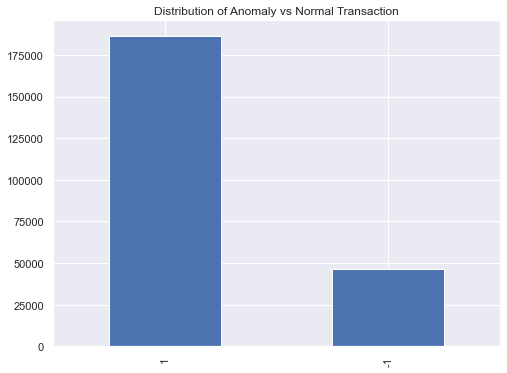

In [59]:
# Lets Barplot out the distribution of Anomaly and Normal

(data2['anomaly'].value_counts().plot(
        kind='bar',
        figsize=(8, 6),
        title='Distribution of Anomaly vs Normal Transaction',
    )
);
# plt.show()

In [60]:
fraud = data2[data2['anomaly']==-1]
normal = data2[data2['anomaly']==1]

In [61]:
print('Fraud shape:',fraud.shape, 'Normal shape:',normal.shape)

Fraud shape: (46608, 4) Normal shape: (186435, 4)


##### We need to analyse more amount of information from the transaction data. How different are the amount of transactions between fraud & normal transaction classes

In [62]:
fraud.transaction.describe()

count    46608.000000
mean       169.108814
std        244.349305
min          0.010000
25%         25.140000
50%        104.365000
75%        169.990000
max        999.970000
Name: transaction, dtype: float64

In [63]:
normal.transaction.describe()

count    186435.000000
mean         54.617710
std          33.642911
min           0.010000
25%          27.380000
50%          48.800000
75%          76.780000
max         162.540000
Name: transaction, dtype: float64

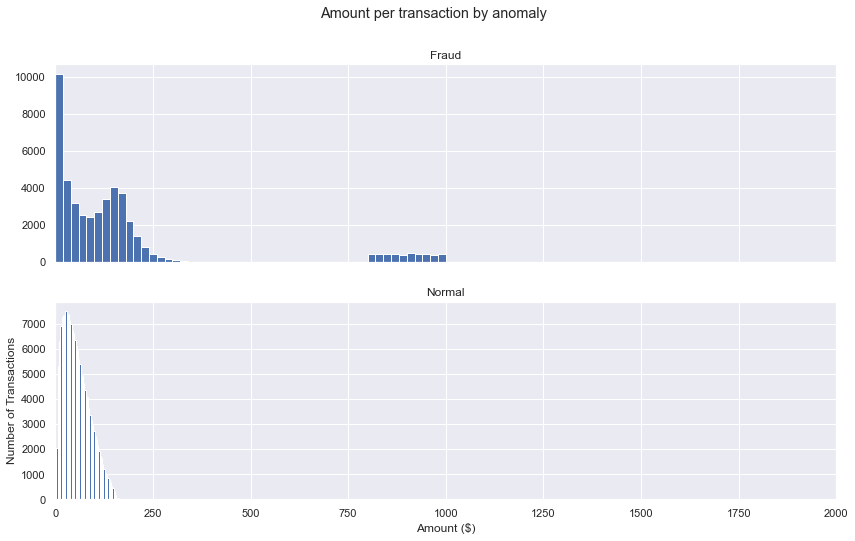

In [67]:
rcParams['figure.figsize']=14,8

f,(ax1, ax2) = plt.subplots(2 ,1, sharex=True)
f.suptitle('Amount per transaction by anomaly')
bins=50
ax1.hist(fraud.transaction, bins = bins)
ax1.set_title('Fraud')
plt.ylabel('Number of Transactions')
ax2.hist(normal.transaction, bins = bins)
plt.xlim((0,2000))

ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0,2000))
#plt.yscale('log')
plt.show();

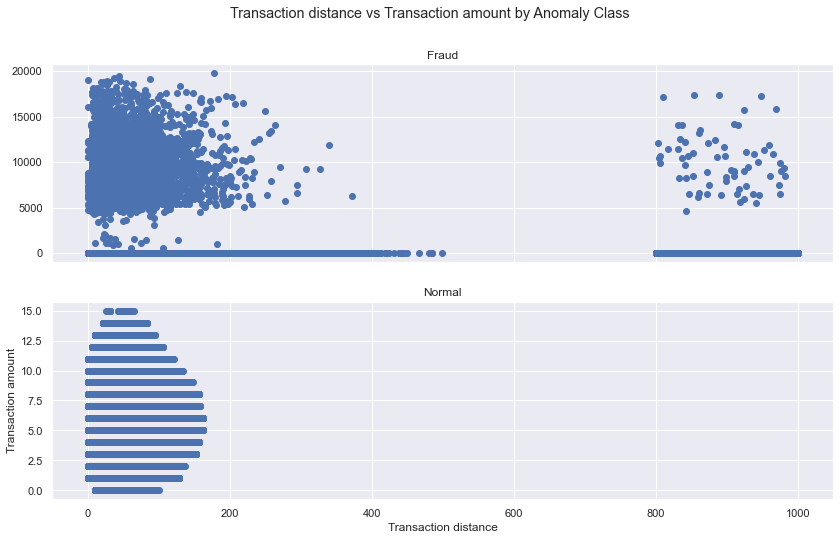

In [69]:
f , (ax1, ax2) = plt.subplots(2,1, sharex=True)
f.suptitle('Transaction distance vs Transaction amount by Anomaly Class')
ax1.scatter(fraud.transaction, fraud.tx_distance)
ax1.set_title('Fraud')
ax2.scatter(normal.transaction, normal.tx_distance)
ax2.set_title('Normal')
plt.xlabel('Transaction distance')
plt.ylabel('Transaction amount')

plt.show()

#### Analysing some fractional amount(10%) of Data

In [70]:
data3 = data2.sample(frac = 0.1, random_state=1)
data3.shape

(23304, 4)

In [71]:
Fraud = data3[data3['anomaly']==-1]
Valid = data3[data3['anomaly']==1]
outlier_fraction = len(Fraud)/len(Valid)

In [72]:
print('Sample fraction: ',outlier_fraction*100)
print('Fraud Cases : {}'.format(len(Fraud)))
print('Valid Cases : {}'.format(len(Valid)))

Sample fraction:  25.03487498658654
Fraud Cases : 4666
Valid Cases : 18638


#### Create independent and dependent features

In [75]:
columns = data3.columns.tolist()
columns = [c for c in columns if c not in ['anomaly']]
target = 'anomaly'
#Define a Random state
state = np.random.RandomState(42)
X = data3[columns]
Y = data3[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0],X.shape[1]))
#print the shapes of X and Y
print('Independent features: ', X.shape)
print('Dependent feature: ',    Y.shape)
#print(X_outliers)

Independent features:  (23304, 3)
Dependent feature:  (23304,)


### Model Predictions using Isolation Forest, LOF & SVM

In [76]:
#Define the outlier detection methods

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1)
   
}

### Compare the results of IsolationForest, LOF & SVM (Run time ~= 5 min.)

In [80]:
n_outliers = len(Fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 1 for Valid transactions , -1 for Fraud transactions
    y_pred[y_pred == 1] = 1
    y_pred[y_pred == -1] = -1
    n_errors = (y_pred != Y).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))

Isolation Forest: 1730
Accuracy Score :
0.9257638173704085
Classification Report :
              precision    recall  f1-score   support

          -1       0.75      0.94      0.84      4666
           1       0.98      0.92      0.95     18638

    accuracy                           0.93     23304
   macro avg       0.87      0.93      0.89     23304
weighted avg       0.94      0.93      0.93     23304

Local Outlier Factor: 5950
Accuracy Score :
0.7446790250600756
Classification Report :
              precision    recall  f1-score   support

          -1       0.39      0.49      0.43      4666
           1       0.86      0.81      0.84     18638

    accuracy                           0.74     23304
   macro avg       0.63      0.65      0.63     23304
weighted avg       0.77      0.74      0.75     23304

Support Vector Machine: 6924
Accuracy Score :
0.7028836251287333
Classification Report :
              precision    recall  f1-score   support

          -1       0.28      0.3

## Observation:

- Isolation Forest detected 1935 errors versus Local Outlier Factor detecting 5649 errors vs. SVM detecting 6917 errors
- Isolation Forest has a 91.7% accuracy compared to LOF of 75.8% and SVM of 70.3%
- When comparing error precision & recall for 3 models , the Isolation Forest performed much better than the LOF as we can see that the detection of fraud cases is around 92% versus LOF detection rate of 52% and SVM of 30%.
- So overall Isolation Forest Method performed much better in determining the fraud cases which is around 92%.
- We can also improve on this accuracy by increasing the sample size or use deep learning algorithms however at the cost of computational expense.We can also use complex anomaly detection models to get better accuracy in determining more fraudulent cases

<a id="VI"></a>
## <span style="color:blue">Part 6. Develop Models to identify Customer exceeding Credit Limits</span>

In [57]:
anomaly_detection_combined = pd.read_csv('anomaly_detection_combined.csv')

#### 5.1 - Filter data by Month

In [58]:
# Filter data by month (May)
filtered_date_month_May = anomaly_detection_combined.loc[(anomaly_detection_combined['date'] >= '2016-05-1')
                     & (anomaly_detection_combined['date'] <= '2016-06-1')]

In [59]:
# Filter data by month (June)
filtered_date_month_June = anomaly_detection_combined.loc[(anomaly_detection_combined['date'] >= '2016-06-1')
                     & (anomaly_detection_combined['date'] <= '2016-07-1')]

In [60]:
# Filter data by month (July)
filtered_date_month_July = anomaly_detection_combined.loc[(anomaly_detection_combined['date'] >= '2016-07-1')
                     & (anomaly_detection_combined['date'] <= '2016-08-1')]

In [61]:
filtered_date_month_May.head()

,user_id,zipcode,state,cc_number,cc_limit,date,transaction,long,lat
3,29421272,3280,NH,4983684529421272,10000,2016-05-27 00:39:42,122.04,-72.159013,43.235530
13,29421272,3280,NH,4983684529421272,10000,2016-06-08 19:17:49,171.74,-72.123999,43.201961
15,29421272,3280,NH,4983684529421272,10000,2016-06-03 18:43:45,264.02,-72.048092,43.197300
18,29421272,3280,NH,4983684529421272,10000,2016-05-29 21:25:22,48.19,-72.022319,43.145022
20,29421272,3280,NH,4983684529421272,10000,2016-06-04 17:44:35,243.58,-72.124434,43.097026


### Creating a new dataframe for the aggregate of Monthly transactions

In [63]:
sum_trans = filtered_date_month_May.groupby('user_id').agg(
    total_no_of_trans   =('transaction', 'nunique'),
    first_trans_date    =('date', 'min'),
    last_trans_date     =('date', 'max'),
    total_trans_amt     =('transaction', 'sum'),
    avg_trans_amt       =('transaction','mean'),
    credit_limit        =('cc_limit', 'mean')
).reset_index().sort_values(by='first_trans_date', ascending=True)

sum_trans.head()

,user_id,total_no_of_trans,first_trans_date,last_trans_date,total_trans_amt,avg_trans_amt,credit_limit
76,9543167,73,2016-05-26 09:39:48,2016-06-09 23:46:42,3580.20,49.043836,4000
799,96648752,52,2016-05-26 11:38:51,2016-06-09 21:43:52,4070.11,78.271346,4000
435,53010194,83,2016-05-26 12:11:19,2016-06-09 23:37:51,12194.06,146.916386,18000
468,57330065,24,2016-05-26 12:39:46,2016-06-09 23:27:04,239.34,9.972500,4000
506,62281327,42,2016-05-26 12:47:19,2016-06-09 23:04:03,4806.91,114.450238,12000


#### 5.2 - Creating  a new feature 'credit_limit_delta' to evaluate delta b/w total transaction and credit limit

In [64]:
sum_trans['credit_limit_delta'] = sum_trans['total_trans_amt'] - sum_trans['credit_limit']

#### 5.3 - Evaluate if total monthly transactions exceeded customer credit limit

In [65]:
sum_trans.loc[sum_trans['credit_limit_delta'] < 0, 'limit_exceeded?'] = 'No' 
sum_trans.loc[sum_trans['credit_limit_delta'] > 0, 'limit_exceeded?'] = 'Yes' 

In [66]:
sum_trans.head(10)

,user_id,total_no_of_trans,first_trans_date,last_trans_date,total_trans_amt,avg_trans_amt,credit_limit,credit_limit_delta,limit_exceeded?
76,9543167,73,2016-05-26 09:39:48,2016-06-09 23:46:42,3580.20,49.043836,4000,-419.80,No
799,96648752,52,2016-05-26 11:38:51,2016-06-09 21:43:52,4070.11,78.271346,4000,70.11,Yes
435,53010194,83,2016-05-26 12:11:19,2016-06-09 23:37:51,12194.06,146.916386,18000,-5805.94,No
468,57330065,24,2016-05-26 12:39:46,2016-06-09 23:27:04,239.34,9.972500,4000,-3760.66,No
506,62281327,42,2016-05-26 12:47:19,2016-06-09 23:04:03,4806.91,114.450238,12000,-7193.09,No
347,41569896,49,2016-05-26 13:02:21,2016-06-09 22:31:31,3718.41,75.885918,8000,-4281.59,No
495,60942592,9,2016-05-26 13:31:16,2016-06-09 18:29:42,554.44,61.604444,8000,-7445.56,No
94,11462736,16,2016-05-26 13:36:42,2016-06-07 21:13:53,1175.97,73.498125,4000,-2824.03,No
511,62956233,89,2016-05-26 13:43:40,2016-06-09 23:59:40,5846.62,65.692360,16000,-10153.38,No
487,60008194,13,2016-05-26 13:43:41,2016-06-09 15:17:39,1072.06,82.466154,7000,-5927.94,No


#### 5.4 - Calculating % of transactions that exceeded the monthly limit

In [67]:
sum_trans['limit_exceeded?'].value_counts()

No     826
Yes      2
Name: limit_exceeded?, dtype: int64

In [68]:
(sum_trans['limit_exceeded?'].value_counts(normalize=True))*100

No     99.758454
Yes     0.241546
Name: limit_exceeded?, dtype: float64

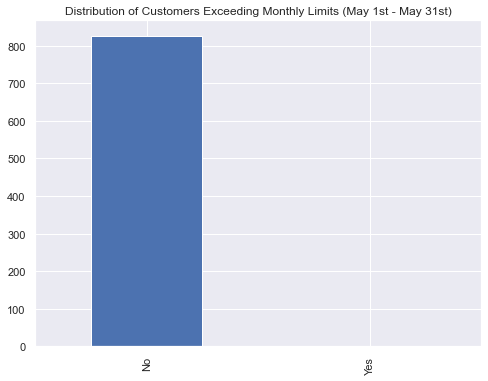

In [69]:
# Lets Barplot out the distribution of Yes and No

(sum_trans['limit_exceeded?'].value_counts().plot(
        kind='bar',
        figsize=(8, 6),
        title='Distribution of Customers Exceeding Monthly Limits (May 1st - May 31st)',
    )
);
plt.show()

In [70]:
feat_sel = ['date', 'transaction']

trans_amt_may = filtered_date_month_May[feat_sel]

In [71]:
trans_amt_may.head()

,date,transaction
3,2016-05-27 00:39:42,122.04
13,2016-06-08 19:17:49,171.74
15,2016-06-03 18:43:45,264.02
18,2016-05-29 21:25:22,48.19
20,2016-06-04 17:44:35,243.58


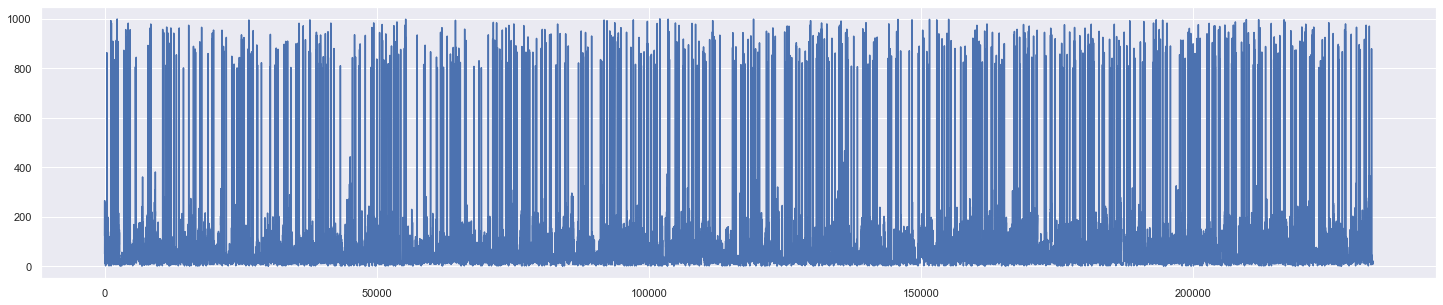

In [85]:
plt.figure(figsize=(25,5))
plt.plot(trans_amt_may.transaction)

## Conclusion:
### Future enhancements: 
### 1.  Improve Timeseries Analysis for Anomaly Detection using PyCaret
### 2.  Add MLOP for Isolation Forest and Timeseries